#  Loading & Exploring data

In [1]:
import criteopy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn

db = cp.AXDBTools()

%reload_ext autoreload
%autoreload 2
%matplotlib inline

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

In [6]:
df = pd.read_csv(r'data/Mall_Customers.csv', header=0)

df.shape

(200, 5)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


/home/a.rouzaud/.local/share/jupyter/.python-kernel/python-kernel-43828/lib64/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc80c1ad320>,
      dtype=object)

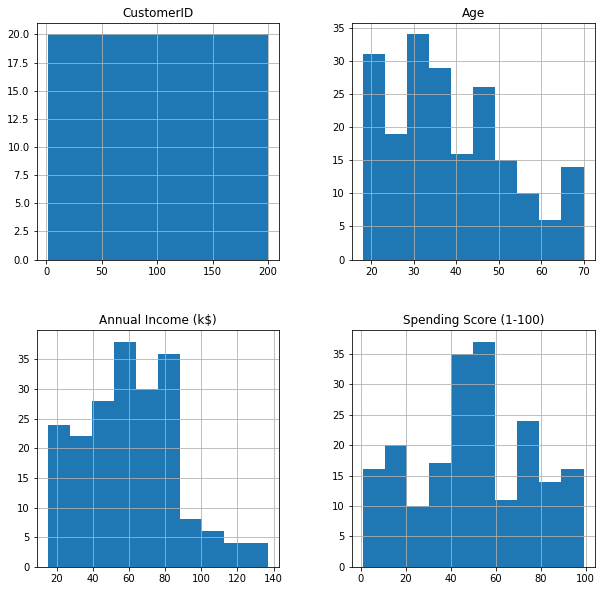

In [14]:
fig = plt.figure(figsize=(10,10))

ax = fig.gca()
df.hist(ax = ax)

In [53]:
df_plot = df.copy()

df_plot.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


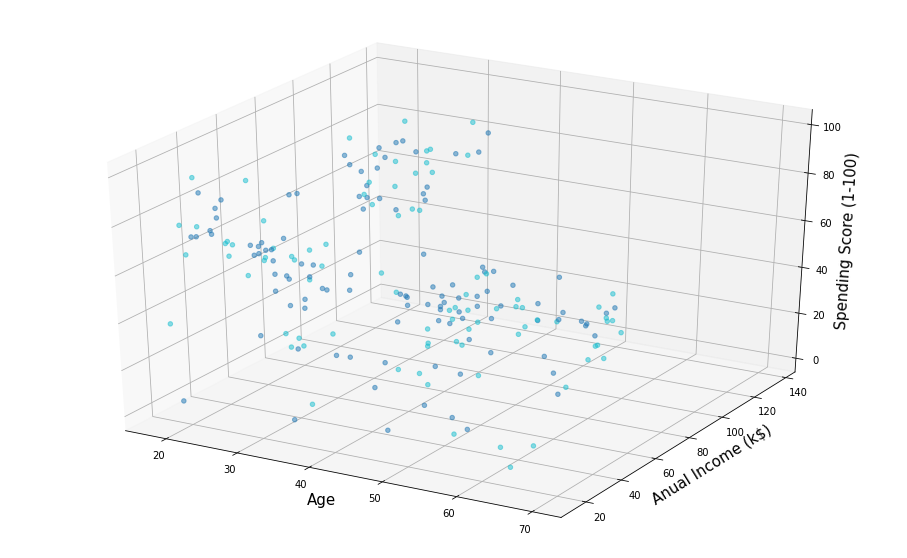

In [67]:
categories = np.unique(df_plot['Gender'])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))  

df_plot["Color"] = df['Gender'].apply(lambda x: colordict[x])

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_plot['Age'].values, 
    ys=df_plot['Annual Income (k$)'].values, 
    zs = df_plot['Spending Score (1-100)'].values,
    cmap='tab10',
    c = df_plot['Color'],
    alpha=0.5
)

ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Anual Income (k$)', fontsize=15)
ax.set_zlabel('Spending Score (1-100)', fontsize=15)

plt.show()

# Cluster Modelling the customer database

In [86]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import silhouette_score

In [250]:
df_final = df.copy()

df_final['is_Male'] = df_final['Gender'].map( {'Male':1, 'Female':0} )
df_final.drop(['Gender', 'CustomerID'],axis = 1, inplace = True)

features = df_final.drop(['is_Male'],axis = 1)
scaled_features = StandardScaler().fit_transform(features)
male_feature = df_final['is_Male'].values.reshape(-1,1)

X = np.hstack((scaled_features,male_feature))
X.shape

(200, 4)

## Finding the optimal number of clusters in Kmeans

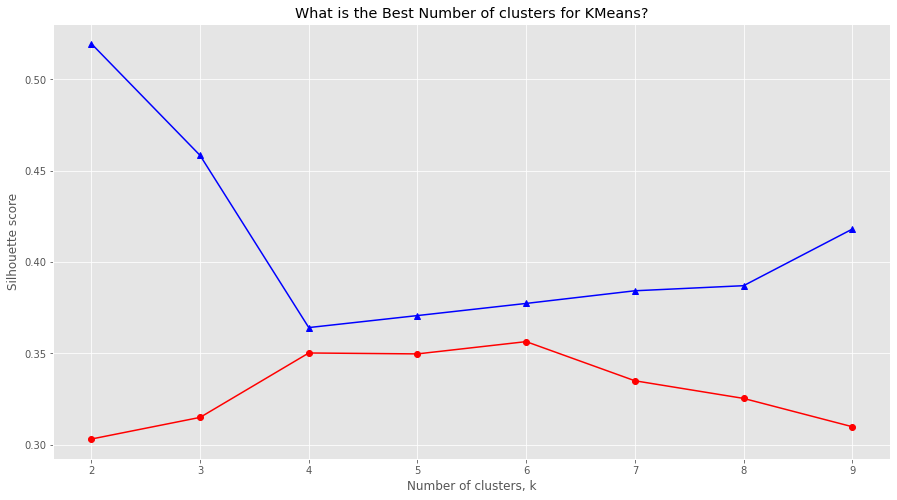

In [259]:
# Computing silhouette coefficient per cluster to get the best cluster number

#The Silhouette Coefficient is calculated using the mean intra-cluster distance (a)
#and the mean nearest-cluster distance (b) for each sample. 
#The Silhouette Coefficient for a sample is (b-a) / max(b-a)

sil_Standard = []
sil_MinMax = []

K = range(2, 10)

X_MinMax = MinMaxScaler().fit_transform(features)
X_MinMax = np.hstack((X_MinMax, male_feature))

for n in K:
    algorithm = (KMeans(n_clusters = n, random_state=41) )
    algorithm.fit(X)
    labels = algorithm.labels_
    sil_Standard.append(silhouette_score(X, labels, metric = 'euclidean'))
    
    algorithm = (KMeans(n_clusters = n,random_state=43) )
    algorithm.fit(X_MinMax)
    labels = algorithm.labels_
    sil_MinMax.append(silhouette_score(X_MinMax, labels, metric = 'euclidean'))

# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
ax.plot(K, sil_Standard, '-o', color = 'r')
ax.plot(K, sil_MinMax, '-^',color = 'b')

plt.xlabel('Number of clusters, k')
plt.ylabel('Silhouette score')
plt.xticks(K)
plt.style.use('ggplot')
plt.title('What is the Best Number of clusters for KMeans?')
plt.show()
#print('the best number of clusters is:' + str(max(sil_Standard.index(max(sil_Standard))+2, sil_MinMax.index(max(sil_MinMax))+2)))

MinMax Scaler seems to perform better

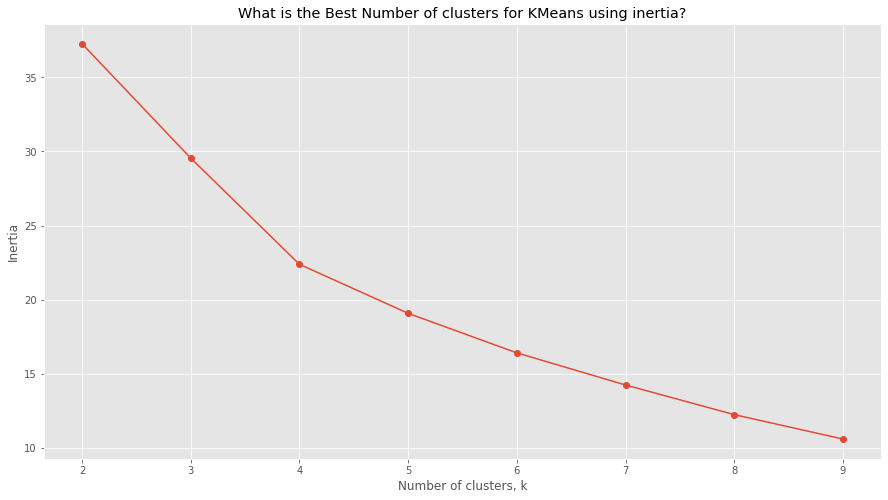

In [252]:
distortions = []
# Number of clusters in range 2-10

K = range(2, 10)
for n in K:
    algorithm = (KMeans(n_clusters = n, random_state=42) )
    algorithm.fit(X_MinMax)
    labels = algorithm.labels_
    distortions.append(algorithm.inertia_)

# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(K, distortions, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(K)
plt.style.use('ggplot')
plt.title('What is the Best Number of clusters for KMeans using inertia?')
plt.show()

Reading the graph above and looking for an 'elbow' pattern, we see the curve starts decreasing less quickly around 4-5 clusters

## Visualising the clusters

In [345]:
final_model_KMeans = KMeans(n_clusters = 4)
final_model.fit(X_MinMax)
y_hat = final_model.predict(X_MinMax)

labels = pd.DataFrame(data = y_hat, columns=['cluster'])

In [347]:
df_clusters = df_final.merge(labels, left_index=True, right_index=True)
df_clusters[df_clusters['cluster'] == 1].head(10)

,Age,Annual Income (k$),Spending Score (1-100),is_Male,cluster
3,23,16,77,0,1
4,31,17,40,0,1
5,22,17,76,0,1
7,23,18,94,0,1
9,30,19,72,0,1
11,35,19,99,0,1
13,24,20,77,0,1
19,35,23,98,0,1
29,23,29,87,0,1
31,21,30,73,0,1


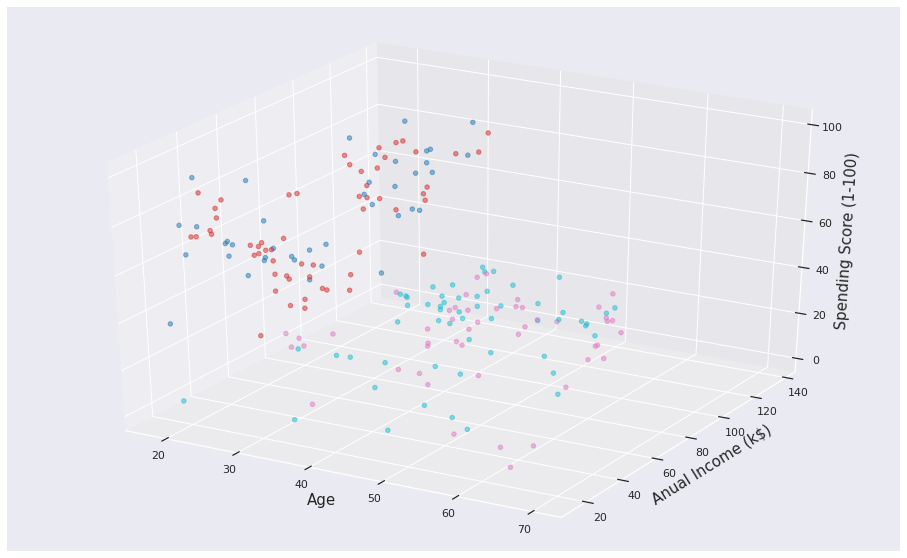

In [348]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_clusters['Age'].values, 
    ys=df_clusters['Annual Income (k$)'].values, 
    zs = df_clusters['Spending Score (1-100)'].values,
    cmap='tab10',
    c = df_clusters['cluster'],
    alpha=0.5
)

ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Anual Income (k$)', fontsize=15)
ax.set_zlabel('Spending Score (1-100)', fontsize=15)

plt.show()

Even with 4 clusters, it seems the model is mixing some observations and does not manage to really segment the customer types. Let's try to have a look with another model. 

## Principal Component Analysis (PCA)

Let's try to reduce the number of features used in the model to reduce the noise and try to obtain better clusters.

In [373]:
def scale_PCA_KMeans_pipeline(df, columns_to_scaled: list,scaler = StandardScaler, pca_components = 4, n_clusters = 4):
    scaled_features = scaler().fit_transform(df[columns_to_scaled])
    other_features = df.drop(columns_to_scaled,axis=1).values
    if other_features.shape[1] == 1:
        other_features = other_features.reshape(-1,1)
    X = np.hstack((scaled_features, other_features))
    
    pca_features = PCA(n_components = pca_components).fit_transform(X)
    km_model = KMeans(n_clusters = n_clusters).fit(pca_features)
    labels = km_model.labels_
    
    return km_model, pca_features, labels

In [382]:
model_standard = scale_PCA_KMeans_pipeline(df_final, columns_to_scaled=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], pca_components=2)
model_minmax = scale_PCA_KMeans_pipeline(df_final, scaler = MinMaxScaler ,columns_to_scaled=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], pca_components=2)

In [386]:
sil_standard = silhouette_score(model_standard[1], model_standard[2])
sil_minmax = silhouette_score(model_minmax[1], model_minmax[2])

print(sil_standard, sil_minmax)

0.42177622653948793 0.6851605920014779


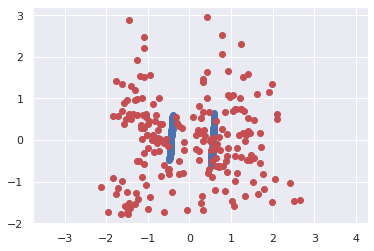

-1.5701715393783767e-16


In [349]:
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.pipeline import make_pipeline

pca_model_minmax = PCA()
pca_model_standard = PCA()

# Apply the fit_transform method of model to grains: pca_features
pca_features_minmax = pca_model_minmax.fit_transform(X_MinMax)
pca_features_standard = pca_model_standard.fit_transform(X)


xm = pca_features_minmax[:,0]
ym = pca_features_minmax[:,1]
plt.scatter(xm, ym, color = 'b')

xs = pca_features_standard[:,0]
ys = pca_features_standard[:,1]
plt.scatter(xs, ys, color = 'r')



plt.axis('equal')
plt.show()

# Calculate the Pearson correlation of xs and ys
correlation, pvalue = pearsonr(xm, ym) 

print(correlation) 

/home/a.rouzaud/.local/share/jupyter/.python-kernel/python-kernel-43828/lib64/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/a.rouzaud/.local/share/jupyter/.python-kernel/python-kernel-43828/lib64/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


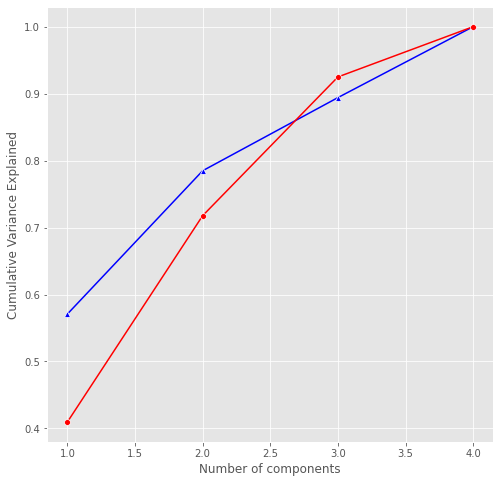

In [255]:
ax = plt.figure(figsize=(8,8))
plot = sns.lineplot(range(1,5), pca_model_minmax.explained_variance_ratio_.cumsum(), marker='^', color = 'b')
plot2 =  sns.lineplot(range(1,5), pca_model_standard.explained_variance_ratio_.cumsum(), marker='o', color = 'r')

plot.set_xlabel('Number of components')
plot.set_ylabel('Cumulative Variance Explained')

plt.show()

Let's consider keeping only 2 dimensions to preserve ~80% of the variance

In [261]:
X_pca_minmax = PCA(n_components = 2).fit_transform(X_MinMax)

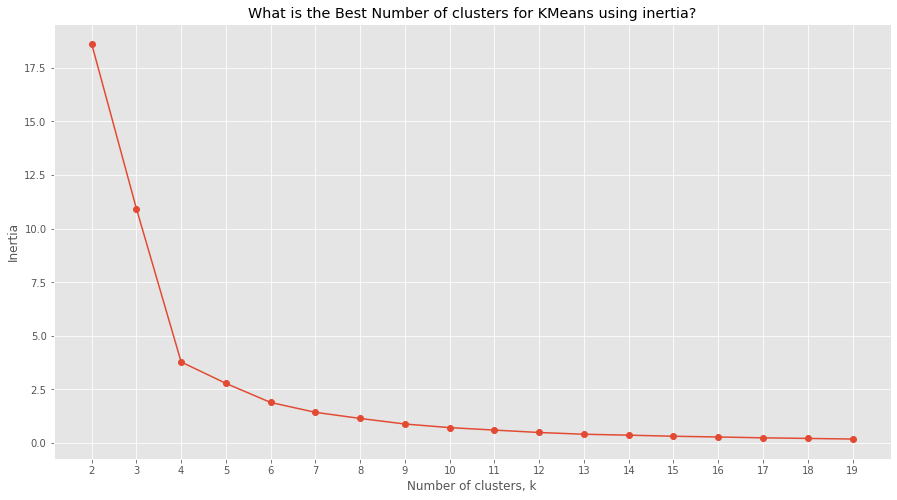

In [262]:
distortions = []
# Number of clusters in range 2-10

K = range(2, 20)
for n in K:
    algorithm = (KMeans(n_clusters = n) )
    algorithm.fit(X_pca_minmax)
    labels = algorithm.labels_
    distortions.append(algorithm.inertia_)

# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(K, distortions, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(K)
plt.style.use('ggplot')
plt.title('What is the Best Number of clusters for KMeans using inertia?')
plt.show()

Here it's even more clear the right number of cluster is 4.

In [319]:
X_pca_minmax = PCA(n_components=4).fit_transform(X_MinMax)
pca_components_minmax = pd.DataFrame(X_pca_minmax).iloc[:,:2]

X_pca_std = PCA(n_components=4).fit_transform(X)
pca_components_std = pd.DataFrame(X_pca_std).iloc[:,:2]

In [320]:
final_model_KM_std = KMeans(n_clusters = 4)
final_model_KM_std.fit(pca_components_std)

final_model_KM_minmax = KMeans(n_clusters = 4)
final_model_KM_minmax.fit(pca_components_minmax)

KMeans(n_clusters=4)

In [321]:
sil_minmax = silhouette_score(pca_components_minmax, final_model_KM_minmax.labels_, metric = 'euclidean')
sil_std = silhouette_score(pca_components_std, final_model_KM_std.labels_, metric = 'euclidean')

In [322]:
df_silhouette_scores = pd.DataFrame({'Scaler': ['minmax', 'standard'],'Silhouette_Score': [sil_minmax,sil_std]})

df_silhouette_scores

,Scaler,Silhouette_Score
0,minmax,0.685161
1,standard,0.421776


### Visualize PCA clusters

In [328]:
df_cluster_pca = df_final.copy()
df_cluster_pca = pd.concat([df_cluster_pca, pd.DataFrame(pca_components_minmax), pd.DataFrame(final_model_KM_minmax.labels_),pd.DataFrame(final_model_KM_std.labels_)],axis=1)
df_cluster_pca.columns.values[-4:] = ['PCA_component_1','PCA_component_2', 'Cluster_MinMax', 'Cluster_Standard']

df_cluster_pca.head()

,Age,Annual Income (k$),Spending Score (1-100),is_Male,PCA_component_1,PCA_component_2,Cluster_MinMax,Cluster_Standard
0,19,15,39,1,0.532955,-0.227841,2,0
1,21,15,81,1,0.513939,-0.493080,2,0
2,20,16,6,0,-0.446266,0.087079,0,2
3,23,16,77,0,-0.478796,-0.366617,3,0
4,31,17,40,0,-0.451984,0.003006,3,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7f771abe0>,
      dtype=object)

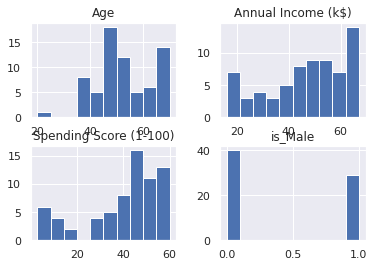

In [335]:
df_cluster_pca[df_cluster_pca['Cluster_Standard'] == 2][['Age', 'Annual Income (k$)','Spending Score (1-100)','is_Male']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7f76694e0>,
      dtype=object)

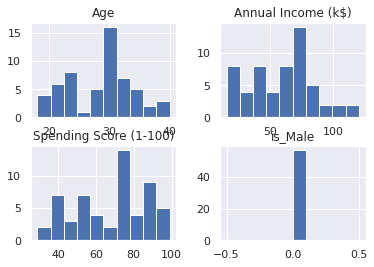

In [339]:
df_cluster_pca[df_cluster_pca['Cluster_MinMax'] == 3][['Age', 'Annual Income (k$)','Spending Score (1-100)','is_Male']].hist()

/home/a.rouzaud/.local/share/jupyter/.python-kernel/python-kernel-43828/lib64/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


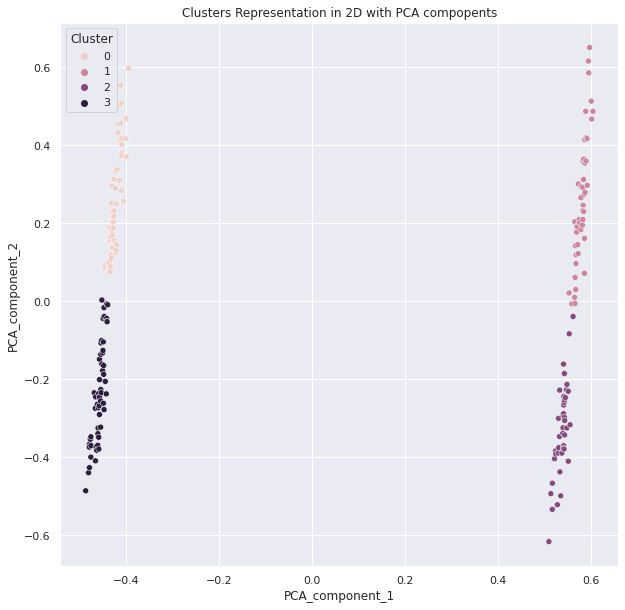

In [325]:
sns.set(style = "darkgrid")

fig = plt.figure(figsize=(10,10))

x_axis = df_cluster_pca['PCA_component_1']
y_axis = df_cluster_pca['PCA_component_2']

sns.scatterplot(x_axis, y_axis, hue = df_cluster_pca['Cluster'])
plt.title('Clusters Representation in 2D with PCA compopents')
plt.show()

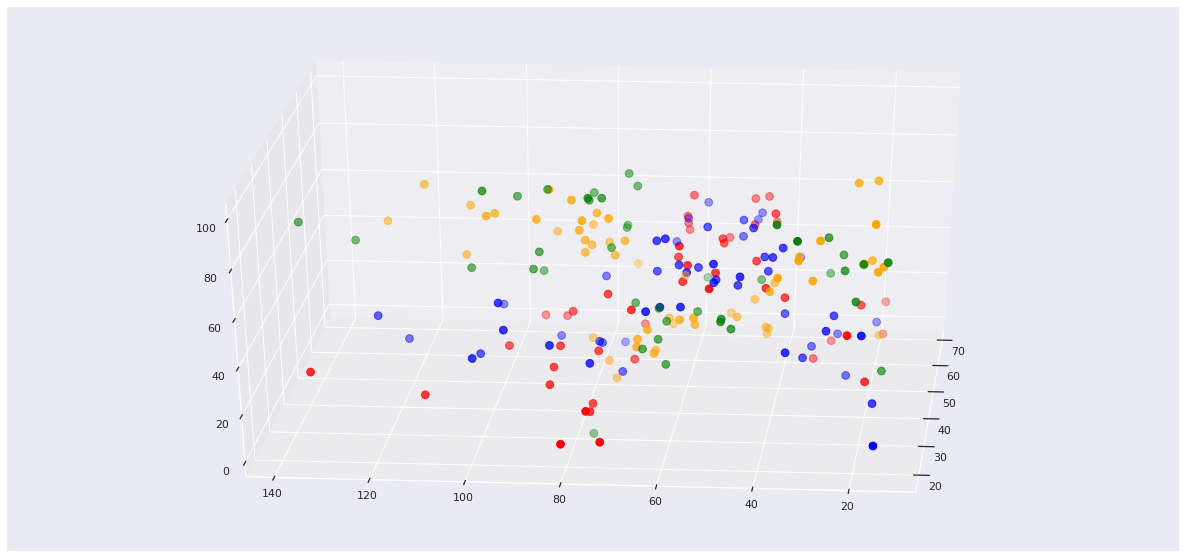

In [329]:
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_cluster_pca.Age[df_cluster_pca.Cluster_MinMax == 0], df_cluster_pca["Annual Income (k$)"][df_cluster_pca.Cluster_MinMax == 0], df_cluster_pca["Spending Score (1-100)"][df_cluster_pca.Cluster_MinMax == 0], c='blue', s=60)
ax.scatter(df_cluster_pca.Age[df_cluster_pca.Cluster_MinMax  == 1], df_cluster_pca["Annual Income (k$)"][df_cluster_pca.Cluster_MinMax == 1], df_cluster_pca["Spending Score (1-100)"][df_cluster_pca.Cluster_MinMax == 1], c='red', s=60)
ax.scatter(df_cluster_pca.Age[df_cluster_pca.Cluster_MinMax == 2], df_cluster_pca["Annual Income (k$)"][df_cluster_pca.Cluster_MinMax == 2], df_cluster_pca["Spending Score (1-100)"][df_cluster_pca.Cluster_MinMax == 2], c='green', s=60)

ax.scatter(df_cluster_pca.Age[df_cluster_pca.Cluster_MinMax  == 3], df_cluster_pca["Annual Income (k$)"][df_cluster_pca.Cluster_MinMax == 3], df_cluster_pca["Spending Score (1-100)"][df_cluster_pca.Cluster_MinMax == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

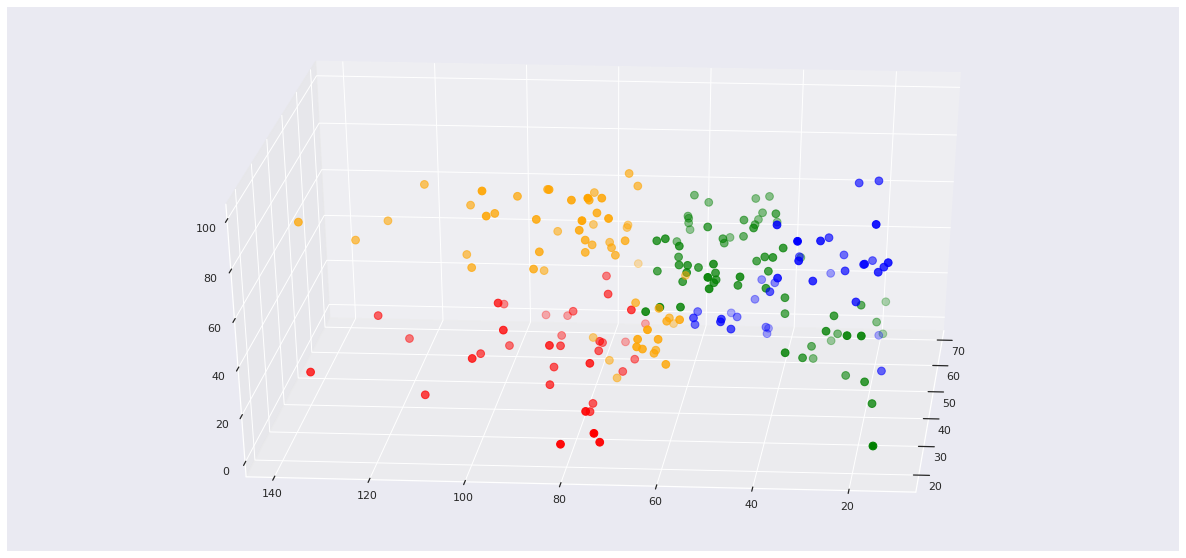

In [331]:
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_cluster_pca.Age[df_cluster_pca.Cluster_Standard == 0], df_cluster_pca["Annual Income (k$)"][df_cluster_pca.Cluster_Standard == 0], df_cluster_pca["Spending Score (1-100)"][df_cluster_pca.Cluster_Standard == 0], c='blue', s=60)
ax.scatter(df_cluster_pca.Age[df_cluster_pca.Cluster_Standard  == 1], df_cluster_pca["Annual Income (k$)"][df_cluster_pca.Cluster_Standard == 1], df_cluster_pca["Spending Score (1-100)"][df_cluster_pca.Cluster_Standard == 1], c='red', s=60)
ax.scatter(df_cluster_pca.Age[df_cluster_pca.Cluster_Standard == 2], df_cluster_pca["Annual Income (k$)"][df_cluster_pca.Cluster_Standard == 2], df_cluster_pca["Spending Score (1-100)"][df_cluster_pca.Cluster_Standard == 2], c='green', s=60)

ax.scatter(df_cluster_pca.Age[df_cluster_pca.Cluster_Standard  == 3], df_cluster_pca["Annual Income (k$)"][df_cluster_pca.Cluster_Standard == 3], df_cluster_pca["Spending Score (1-100)"][df_cluster_pca.Cluster_Standard == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

It means the model standardised with MinMax overconsiders the Gender in the PCA Dimensions, and thus does not really manage to cluster correctly the rest of the features. They seem to get better importance with a StandardScaler that reduces the variance.

# Let's build personas around these clusters

In [342]:
df_cluster_pca.groupby(['Cluster_Standard'])[['Age', 'Annual Income (k$)','Spending Score (1-100)']].mean()

,Age,Annual Income (k$),Spending Score (1-100)
Cluster_Standard,,,
0,25.605263,32.631579,67.500000
1,41.685714,88.228571,17.285714
2,52.144928,46.333333,40.072464
3,30.000000,79.086207,70.775862


We get some clear profiles out of these clusters:
- cluster 0 represents young users that do not care much about savings and spend a lot.
- cluster 1 represents wealthy people care a lot about how they spend their money. They consider every big expense they do, and should be attracted by special offers with discounts.
- cluster 2 represents middle-class older people, saving their income for the retirement probably.
- finally, cluster 3 represent new wealthy young people, living an enthusiastic life with a lot of materials bought to fulfill their needs.